# CS188 Assignment 1-1: Dataloader

Before we start, please put your name and UD in following format

: Firstname LASTNAME, #00000000   //   e.g.) Yining Hong, #123456789

**Your Answer:**   
Kevin Tang, #805419480

In this notebook you will implement the dataloader on the TinyPlaces dataset you created.

The dataloader will take in the tinyplaces-train and tinyplaces-val files you create, turn them into pytorch tensors.

if binary is set to False, it will take in the tinyplaces-train-multiclass and tinyplaces-val-multilclass files you create.

If necessary, the dataloader should be able to sample how many data you want and return a sub-sampled dataset.

The goal of this exercise is to get you started with how to load data using [PyTorch](https://pytorch.org/).

# Setup Code
Before getting started we need to run some boilerplate code to set up our environment. You'll need to rerun this setup code each time you start the notebook.

First, run this cell load the [autoreload](https://ipython.readthedocs.io/en/stable/config/extensions/autoreload.html?highlight=autoreload) extension. This allows us to edit `.py` source files, and re-import them into the notebook for a seamless editing and debugging experience.

In [165]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Google Colab Setup
Next we need to run a few commands to set up our environment on Google Colab.

Run the following cell to mount your Google Drive. Follow the link, sign in to your Google account (the same account you used to store this notebook!) and copy the authorization code into the text box that appears below.

In [166]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Now examine if you can access the assignment folder.

In [167]:
import os

# TODO: Fill in the Google Drive path where you uploaded the assignment
# Example: If you create a 188 folder and put all the files under Assignment1 folder, then '188/Assignment1'
# GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = '188/Assignment1'
# G:\My Drive\kevintang2023@ucla.edu\Documents\Classes\2022W\CS188\Workspace\Assignment1
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'kevintang2023@ucla.edu/Documents/Classes/2022W/CS188/Workspace/Assignment1'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['README.md', 'categories_tinyplaces.txt', 'cs188', 'knn.ipynb', 'knn.py', 'regression.ipynb', 'regression.py', 'tinyplaces_creator.py', '__pycache__', 'data', 'data_loader.ipynb', 'val.txt', 'train.txt']


Once you have successfully mounted your Google Drive and located the path to this assignment, run th following cell to allow us to import from the `.py` files of this assignment. If it works correctly, it should print the message:

```
Hello from regression.py!
```

as well as the last edit time for the file `regression.py`.

In [168]:
import sys
sys.path.append(GOOGLE_DRIVE_PATH)

import time, os
os.environ["TZ"] = "US/Eastern"
time.tzset()

from regression import hello
hello()

path = os.path.join(GOOGLE_DRIVE_PATH, 'regression.py')
edit_time = time.ctime(os.path.getmtime(path))
print('regression.py last edited on %s' % edit_time)

Hello from regression.py!
regression.py last edited on Sat Jan 22 18:29:06 2022


# Data preprocessing / Visualization

## Setup code
Run some setup code for this notebook: Import some useful packages and increase the default figure size.

In [169]:
import torch
import torchvision
import cs188
import matplotlib.pyplot as plt
import statistics

plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['font.size'] = 16

## Load the Tinyplaces dataset
The utility function `data.tinyplaces()` returns the entire tinyplaces dataset as a set of four **Torch tensors**:

- `x_train` contains all training images (real numbers in the range $[0, 1]$)
- `y_train` contains all training labels (integers in the range $[0, 1]$)
- `x_val` contains all validation images
- `y_val` contains all validation labels

In [170]:
x_train, y_train, x_val, y_val = cs188.data.tinyplaces(GOOGLE_DRIVE_PATH)

print('Training set:', )
print('  data shape:', x_train.shape)
print('  labels shape: ', y_train.shape)
print('Validation set:')
print('  data shape: ', x_val.shape)
print('  labels shape', y_val.shape)

Training set:
  data shape: torch.Size([10000, 3, 32, 32])
  labels shape:  torch.Size([10000])
Validation set:
  data shape:  torch.Size([1000, 3, 32, 32])
  labels shape torch.Size([1000])


## Visualize the dataset
This cell visualizes some random examples from the training set. We will first try the binary classification dataset.

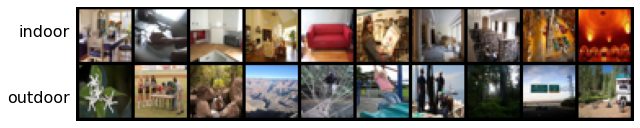

In [171]:
import random
from torchvision.utils import make_grid

classes = ['indoor', 'outdoor']
samples_per_class = 10
samples = []
for y, cls in enumerate(classes):
    plt.text(-4, 40 * y + 18, cls, ha='right')
    idxs, = (y_train == y).nonzero(as_tuple=True)
    for i in range(samples_per_class):
        idx = idxs[random.randrange(idxs.shape[0])].item()
        samples.append(x_train[idx])
img = torchvision.utils.make_grid(samples, nrow=samples_per_class)
plt.imshow(cs188.tensor_to_image(img))
plt.axis('off')
plt.show()

For the multi-class version

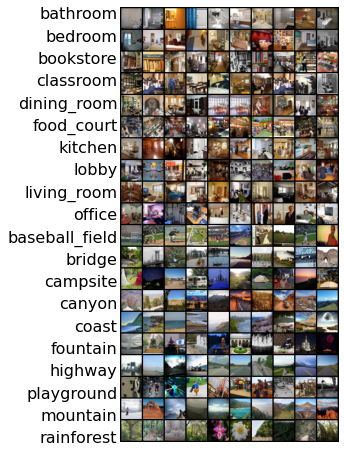

In [172]:
x_train, y_train, x_val, y_val = cs188.data.tinyplaces(GOOGLE_DRIVE_PATH, binary=False)

samples_per_class = 10
samples = []
classes = ['bathroom', 'bedroom', 'bookstore', 'classroom', 'dining_room', 'food_court', 'kitchen', 'lobby', 'living_room', 'office', 'baseball_field', 'bridge', 'campsite', 'canyon', 'coast', 'fountain', 'highway', 'playground', 'mountain', 'rainforest']
for y, cls in enumerate(classes):
    plt.text(-4, 35 * y + 18, cls, ha='right')
    idxs, = (y_train == y).nonzero(as_tuple=True)
    for i in range(samples_per_class):
        idx = idxs[random.randrange(idxs.shape[0])].item()
        samples.append(x_train[idx])
img = torchvision.utils.make_grid(samples, nrow=samples_per_class)
plt.imshow(cs188.tensor_to_image(img))
plt.axis('off')
plt.show()

## Subsample the dataset
When implementing machine learning algorithms, it's usually a good idea to use a small sample of the full dataset. This way your code will run much faster, allowing for more interactive and efficient development. Once you are satisfied that you have correctly implemented the algorithm, you can then rerun with the entire dataset.

The function `cs188.data.tinyplaces()` can automatically subsample the TinyPlaces dataset for us. To see how to use it, we can check the documentation using the built-in `help` command:

In [173]:
help(cs188.data.tinyplaces)

Help on function tinyplaces in module cs188.data:

tinyplaces(path='', num_train=None, num_val=None, feature=False, binary=True, use_gpu=False)
    Return the TinyPlaces dataset.
    This function can also subsample the dataset.
    
    Inputs:
    - num_train: [Optional] How many samples to keep from the training set.
      If not provided, then keep the entire training set.
    - num_val: [Optional] How many samples to keep from the val set.
      If not provided, then keep the entire val set.
    - feature: [Optional] If True, extract features from the images instead of using raw pixel values.
    - binary: [Optional] If false, perform multi-class classification instead of binary classification.
    
    Returns:
    - x_train: float32 tensor of shape (num_train, 3, 32, 32) / If feature is true, (num_train, 3, 256)
    - y_train: int64 tensor of shape (num_train, )
    - x_val: float32 tensor of shape (num_val, 3, 32, 32) / If feature is true, (num_val, 3, 256)
    - y_val: int64 t

We will subsample the data to use only 100 training examples and validation examples:

In [174]:
num_train = 100
num_val = 100

x_train, y_train, x_val, y_val = cs188.data.tinyplaces(GOOGLE_DRIVE_PATH, num_train, num_val)

print('Training set:', )
print('  data shape:', x_train.shape)
print('  labels shape: ', y_train.shape)
print('validation set:')
print('  data shape: ', x_val.shape)
print('  labels shape', y_val.shape)

Training set:
  data shape: torch.Size([100, 3, 32, 32])
  labels shape:  torch.Size([100])
validation set:
  data shape:  torch.Size([100, 3, 32, 32])
  labels shape torch.Size([100])
